In [46]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_score, recall_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import joblib
import json

In [47]:
# Carregamento do dataset e análise inicial dos dados

df = pd.read_csv('C:\\Users\\leona\\Desktop\\Projetos Sci-Kit Learn\\Churn Analysis\\Telco-Customer-Churn.csv')

df.head()
df.info()
df.isnull().sum()

df['Churn'].value_counts(normalize=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


Churn
No     0.73463
Yes    0.26537
Name: proportion, dtype: float64

In [53]:
# Divisão dos dados em features e target

X = df.drop(['Churn', 'customerID'], axis=1)
y = df["Churn"].map({"No":0, "Yes":1})

In [54]:
# Divisão dos dados em treino e teste com stratify (garante que a proporção das classes se mantenha)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)

In [55]:
# Pré-processamento dos dados usando pipelines e ColumnTransformer

num_cols = X.select_dtypes(include=['int64', 'float64']).columns # identificação das colunas numéricas
cat_cols = X.select_dtypes(include=['object']).columns # identificação das colunas categóricas

num_pipeline = Pipeline([('imputer', SimpleImputer(strategy='median')), # aplicando pipeline para imputar a mediana em valores faltantes e uniformizando os dados numéricos na mesma escala
                        ('scaler', StandardScaler())])

cat_pipeline = Pipeline([('imputer', SimpleImputer(strategy='constant', fill_value='missing')), # aplicando pipeline para imputar valores faltantes nas colunas categóricas e aplicando one-hot encoding
                        ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer([    # aplicando a função ColumnTransformer para aplicar os pipelines nas colunas correspondentes (numéricas e categóricas)
    ('num', num_pipeline, num_cols),
    ('cat', cat_pipeline, cat_cols)
])

In [56]:
# Treinamento do modelo RandomForestClassifier usando pipeline

model = Pipeline([
    ('prep', preprocessor),
    ('clf', RandomForestClassifier(
        n_estimators = 300,
        max_depth = None,
        random_state = 42
    ))
])
model.fit(X_train, y_train)

,steps,"[('prep', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [57]:
# Fazendo predições e avaliando o modelo

y_pred = model.predict(X_test)

y_proba = model.predict_proba(X_test)[:, 1] # probabilidade da classe positiva

In [58]:
cm = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:\n', cm)

print("\nClassification report:\n")
print(classification_report(y_test, y_pred, digits=4))

Confusion Matrix:
 [[930 105]
 [196 178]]

Classification report:

              precision    recall  f1-score   support

           0     0.8259    0.8986    0.8607      1035
           1     0.6290    0.4759    0.5419       374

    accuracy                         0.7864      1409
   macro avg     0.7275    0.6872    0.7013      1409
weighted avg     0.7737    0.7864    0.7761      1409



AUC: 0.8205


Text(0, 0.5, 'TPR')

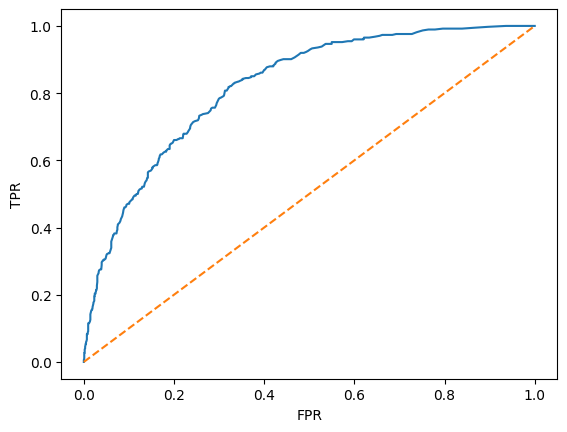

In [60]:
# Curvas ROC e AUC


fpr, tpr, thresholds_roc = roc_curve(y_test, y_proba)
auc = roc_auc_score(y_test, y_proba)
print(f'AUC: {auc:.4f}')

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')  # linha diagonal
plt.xlabel('FPR')
plt.ylabel('TPR')



Average Precision (AP): 0.6100


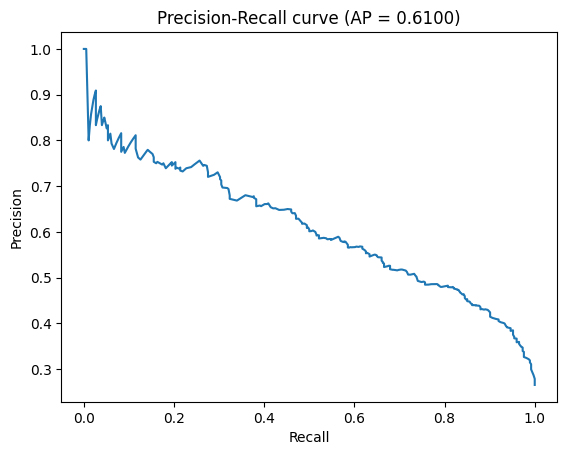

In [61]:
# Métricas de Precisão e Recall do Sklearn

precision, recall, thresholds_pr = precision_recall_curve(y_test, y_proba)
ap = average_precision_score(y_test, y_proba)
print(f'Average Precision (AP): {ap:.4f}')

plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall curve (AP = {ap:.4f})')
plt.show()

In [62]:
# Escolhendo um threshold específico e calculando precisão e recall

desired_recall = 0.8

best_threshold = 0
best_precision = 0

for t in thresholds_pr:
    y_pred_t = (y_proba >= t).astype(int)
    rec = recall_score(y_test_bin, y_pred_t)
    prec = precision_score(y_test_bin, y_pred_t)

    if rec >= desired_recall and prec > best_precision:
        best_precision = prec
        best_threshold = t

print("Melhor threshold:", best_threshold)
print("Precision nesse threshold:", best_precision)
print("Recall (>= desejado):", desired_recall)

Melhor threshold: 0.23
Precision nesse threshold: 0.48242811501597443
Recall (>= desejado): 0.8


In [63]:
y_pred_opt = (y_proba >= best_threshold).astype(int)

In [64]:
# Fazendo grid search com cross-validation estratificado para otimização de hiperparâmetros

model = Pipeline([
    ('prep', preprocessor),
    ('clf', RandomForestClassifier(random_state=42))
])

In [65]:
# Criando um dicionário com os hiperparâmetros a serem testados no grid search

params = {
    'clf__n_estimators': [100, 300],
    'clf__max_depth': [None, 10, 20],
    'clf__min_samples_split': [2, 5],
    'clf__min_samples_leaf': [1, 2]
}

In [66]:
# construindo o objeto GridSearchCV com validação cruzada estratificada

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(estimator=model,
                    param_grid=params,
                    scoring= 'roc_auc',
                    cv = cv,
                    n_jobs = -1,
                    verbose = 1)

In [67]:
grid.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'clf__max_depth': [None, 10, ...], 'clf__min_samples_leaf': [1, 2], 'clf__min_samples_split': [2, 5], 'clf__n_estimators': [100, 300]}"
,scoring,'roc_auc'
,n_jobs,-1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('num', ...), ('cat', ...)]"


In [68]:
print("Best params:", grid.best_params_)
print("Best AUC:", grid.best_score_)
best_model = grid.best_estimator_

Best params: {'clf__max_depth': 20, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 5, 'clf__n_estimators': 300}
Best AUC: 0.8384003087318987


In [69]:
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]
print("AUC test:", roc_auc_score(y_test, y_proba))

AUC test: 0.826278126533881


In [70]:
# lista todos os parâmetros nomeados que você pode usar no grid
list(model.get_params().keys())

['memory',
 'steps',
 'transform_input',
 'verbose',
 'prep',
 'clf',
 'prep__force_int_remainder_cols',
 'prep__n_jobs',
 'prep__remainder',
 'prep__sparse_threshold',
 'prep__transformer_weights',
 'prep__transformers',
 'prep__verbose',
 'prep__verbose_feature_names_out',
 'prep__num',
 'prep__cat',
 'prep__num__memory',
 'prep__num__steps',
 'prep__num__transform_input',
 'prep__num__verbose',
 'prep__num__imputer',
 'prep__num__scaler',
 'prep__num__imputer__add_indicator',
 'prep__num__imputer__copy',
 'prep__num__imputer__fill_value',
 'prep__num__imputer__keep_empty_features',
 'prep__num__imputer__missing_values',
 'prep__num__imputer__strategy',
 'prep__num__scaler__copy',
 'prep__num__scaler__with_mean',
 'prep__num__scaler__with_std',
 'prep__cat__memory',
 'prep__cat__steps',
 'prep__cat__transform_input',
 'prep__cat__verbose',
 'prep__cat__imputer',
 'prep__cat__onehot',
 'prep__cat__imputer__add_indicator',
 'prep__cat__imputer__copy',
 'prep__cat__imputer__fill_value',

In [72]:
# Salvar o modelo para fazer o deploy no Streamlit
joblib.dump(best_model, 'churn_model.pkl')

['churn_model.pkl']